# Sarcasm Detection on News headlines

In [1]:
import torch
import math
import rich
import json
import nltk
from functools import partial
from pathlib import Path
from torch  import nn
from tqdm   import tqdm
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import transformers
import unicodedata
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

sns.set()

/Users/xyc/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cpu

In [3]:
# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

# prepare data for the later cells
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)},
                                                                   unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [00:25<00:00, 15440.81it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

In [4]:
df = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json",
                  lines=True)
df = df.drop('article_link', axis = 1)

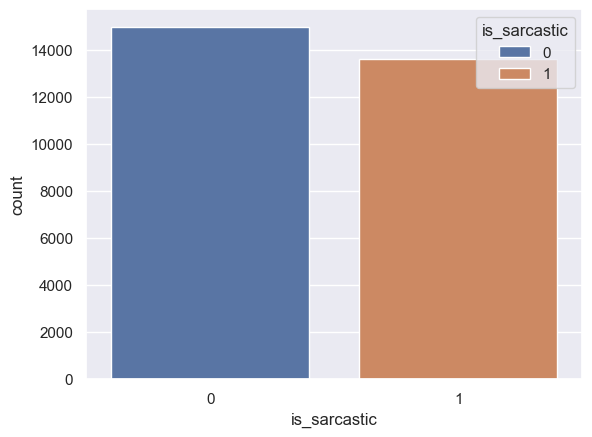

In [5]:
sns.countplot(data=df, x="is_sarcastic",hue="is_sarcastic")
plt.show()

In [6]:
# Example sentence with rare English words and non-english words
sentence = df.at[2741, 'headline']
rich.print(f"Input sentence: [bold blue]`{sentence}`")

# Define multiple tokenizers
tokenizer_ids = {
    "Word-level": glove_tokenizer,
    "WordPiece": "bert-base-cased",
    "BPE": "distilgpt2",
    "Character-level":  "google/byt5-small",
    }

# iterate through the tokenizers and decode the input sentences
for tokenizer_name, tokenizer in tokenizer_ids.items():
    # intialize the tokenizer (either)
    if isinstance(tokenizer, str):
        # init a `transformers.PreTrainedTokenizerFast`
        tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer)
        vocab_size = tokenizer.vocab_size
    else:
        # use the provided `tokenizers.Tokenizer``
        vocab_size = tokenizer.get_vocab_size()

    # Tokenize
    token_ids = tokenizer.encode(sentence, add_special_tokens=False)
    if isinstance(token_ids, tokenizers.Encoding):
        token_ids = token_ids.ids

    # Report
    rich.print(f"[red]{tokenizer_name}[/red]: sentence converted into {len(token_ids)} tokens (vocabulary: {vocab_size} tokens)")
    rich.print(f"Tokens:\n{[tokenizer.decode([t]) for t in token_ids]}")
    rich.print(f"Token ids:\n{[t for t in token_ids]}")

Input sentence: `proud to be a total b*tch`

Word-level: sentence converted into 8 tokens (vocabulary: 400001 tokens)

Tokens:
['proud', 'to', 'be', 'a', 'total', 'b', '*', 'tch']

Token ids:
[4287, 4, 30, 7, 477, 1556, 13697, 154788]

WordPiece: sentence converted into 9 tokens (vocabulary: 28996 tokens)

Tokens:
['proud', 'to', 'be', 'a', 'total', 'b', '*', 't', '##ch']

Token ids:
[6884, 1106, 1129, 170, 1703, 171, 115, 189, 1732]

BPE: sentence converted into 9 tokens (vocabulary: 50257 tokens)

Tokens:
['p', 'roud', ' to', ' be', ' a', ' total', ' b', '*', 'tch']

Token ids:
[79, 5493, 284, 307, 257, 2472, 275, 9, 38664]

Character-level: sentence converted into 25 tokens (vocabulary: 384 tokens)

Tokens:
['p', 'r', 'o', 'u', 'd', ' ', 't', 'o', ' ', 'b', 'e', ' ', 'a', ' ', 't', 'o', 't', 'a', 'l', ' ', 'b', '*', 't',
'c', 'h']

Token ids:
[115, 117, 114, 120, 103, 35, 119, 114, 35, 101, 104, 35, 100, 35, 119, 114, 119, 100, 111, 35, 101, 45, 119, 102, 
107]

In [7]:
df_textonly = df[~df['headline'].astype(str).str.contains(r'\d')]

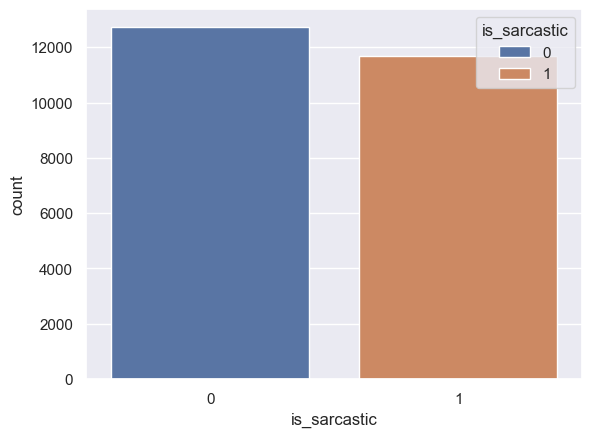

In [8]:
sns.countplot(data=df_textonly, x="is_sarcastic",hue="is_sarcastic")
plt.show()

In [9]:
df_textonly = df_textonly.reset_index().drop(columns='index')

In [10]:
def remove_non_ascii(text):
    # using unicodedata.normalize to convert unicode into ASCII
    normalized_text = unicodedata.normalize('NFKD', text)

    # removing any non-ASCII
    ascii_text = normalized_text.encode('ascii', 'ignore').decode('ascii')
    return ascii_text

df_textonly['headline'] = df_textonly['headline'].apply(remove_non_ascii)

In [11]:
df_textonly['headline'] = df_textonly['headline'].str.replace(r'[.,:;()\'"?+!&$]', '', 
                                                              regex=True)
df_textonly['headline'] = df_textonly['headline'].str.replace(r'—+', ' ', regex=True) 
df_textonly['headline'] = df_textonly['headline'].str.replace(r'-+', ' ', regex=True) 
df_textonly['headline'] = df_textonly['headline'].str.replace(r'/', ' ', regex=True)

In [12]:
# replace sensitive words
sensitive_words = {
    r'\bf\*+kup\b': 'fuckup',
    r'\bf\*+king\b': 'fucking',
    r'\bf\*+c?k?\b': 'fuck',
    r'\bf\*\*\*': 'fuck',
    r'\bsh?\*+t\b': 'shit',
    r'\bp\*+(s+)?y\b': 'pussy',
    r'\bb\*+t?c?h\b': 'bitch',
    r'\bb\*+s\b': 'bitches',
    r'\ba\*\*\b': 'ass',
    r'\bn\*+a\b': 'nigga',
    r'\bn\*+r\b': 'nigger',
    r'\bb\*+d\b': 'bastard',
    r'\btr\*mp\b': 'trump',
    r'\bd\*ck\b': 'dick',
    r'\bbullsh?\*+t\b': 'bullshit',
    r'\bmotherf\*+ker\b': 'motherfucker',
}

for pattern, replacement in sensitive_words.items():
    df_textonly['headline'] = df_textonly['headline'].str.replace(pattern, 
                                                                  replacement,
                                                                  regex=True)

In [13]:
for i in [2873, 6726, 8215, 13154, 23422]:
    print(df_textonly.at[i-2, 'headline'])
    df_textonly.drop(i-2, inplace=True)

b*a*p*s rented on strength of academy award winning stars
huffpost hill   have *you* been injured by a federal appellate court ruling
three dozen confirmed *@@## in power plant *@@##
from music festivals to college campuses trans* and womens communities
an oral history of *nsyncs breakup according to bandmates not named justin timberlake


**A final clean version of data**

In [14]:
df_textonly.to_csv('clean_data.csv', index=False)